In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as pl
from scipy.stats import multivariate_normal, norm
import random
import math
from sklearn.datasets import load_wine

### Gaussian Mixture Models Class ###

In [2]:
class GMM():
    def __init__(self, data, k, iter):
        self.k = k
        self.iter = iter
        self.cont = 1
        self.likelihood = 0
        return

    def normal_multi(self, mean, cov, data):
        det = np.linalg.det(cov)
        det = np.abs(det) ** (1 / 2)
        constant = 1 / ((2 * np.pi) ** (data.shape[1] / 2) * det)
        data_mean_diff = data - mean
        exponent = -0.5 * np.sum(data_mean_diff @ np.linalg.inv(cov) * data_mean_diff, axis=1)
        return np.exp(exponent) * constant
    
    def expectation(self, data):
        responsibilities = np.zeros((len(data), self.k))

        for j in range(self.k):
            responsibilities[:, j] = self.normal_multi(self.means[j, :], self.covariances[j], data)

        sum_prob = np.sum(responsibilities, axis=1, keepdims=True)
        responsibilities /= sum_prob

        self.responsibilities = responsibilities
        return

    def maximization(self, data, responsibilities):
        means = self.means
        covariances = self.covariances
        k = self.k
        prior_prob = self.prior_prob
        Nk = np.sum(responsibilities, axis=0)
        sum_loop = np.dot(responsibilities.T, data)
        means = sum_loop / Nk[:, np.newaxis]

        data_minus_means = data[:, np.newaxis, :] - means
        covariances = np.sum((responsibilities[:, :, np.newaxis, np.newaxis] * data_minus_means[:, :, :, np.newaxis]) @ data_minus_means[:, :, np.newaxis, :], axis=0) / Nk[:, np.newaxis, np.newaxis]
        for j in range(k):
            covariances[j] += 1e-8 * np.eye(data.shape[1])
            
        prior_prob = Nk / len(data)
        return covariances, means, prior_prob


    def preprocess(self, data):
        n = data.shape[0]
        visited = np.zeros(n)
        clusters_num = 0

        prior_prob = np.zeros(self.k)
        # np.random.seed(60)
        means = np.random.rand(self.k, data.shape[1])
        covariances = []
        for i in range(self.k):
            covariance = np.cov(np.transpose(data))
            covariances.append(covariance)

        while clusters_num < self.k:
            index = np.random.randint(n)
            if (visited[index]):
                continue
            prob = np.random.random()
            prior_prob[clusters_num] = prob
            clusters_num += 1
        sum = np.sum(prior_prob)
        prior_prob = prior_prob / sum

        self.prior_prob = prior_prob
        self.means = means
        self.covariances = covariances
        return


    def fit(self, data):
        self.preprocess(data)
        # for i in range(self.iter):
            # self.expectation(data)
            # self.covariances, self.means, self.prior_prob = self.maximization(data, self.responsibilities)

        while not self.log_likelihood(data):
            self.expectation(data)
            self.covariances, self.means, self.prior_prob = self.maximization(data, self.responsibilities)
        return
    
    def get_parameters(self):
        return self.means, self.covariances, self.prior_prob

    def log_likelihood(self, data):

        weighted_normals = np.zeros((len(data), self.k))
        for j in range(self.k):
            weighted_normals[:, j] = self.prior_prob[j] * self.normal_multi(self.means[j, :], self.covariances[j], data)

        sum_weighted_normals = np.sum(weighted_normals, axis=1)
        log_like = np.sum(np.log(sum_weighted_normals))

        if abs(self.likelihood - log_like) < 1e-5:
            self.likelihood = log_like
            return True

        self.likelihood = log_like
        return False
    

    def predict(self):
        return np.argmax(self.responsibilities, axis = 1)

### Customer Dataset GMM ###

In [4]:
path = './SMAI-Dataset-customer-dataset/data.csv'
file = pd.read_csv(path)
file = file.drop(columns='Index')
file = file.dropna().fillna(0)
file

,Gender,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,67,2,124670,1,2
1,1,1,22,1,150773,1,2
2,0,0,49,1,89210,0,0
3,0,0,45,1,171565,1,1
4,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0
1996,1,1,27,1,117744,1,0
1997,0,0,31,0,86400,0,0
1998,1,1,24,1,97968,0,0


In [5]:
data = np.array([file])
data = np.reshape(data, (data.shape[1], data.shape[2]))

gmm = GMM(data, 1, 7)
if (gmm.cont == 0):
    exit(0)
gmm.fit(data)
means, covariances, prior_prob = gmm.get_parameters()
print(means)
print(covariances)
print(prior_prob)

[[4.57000000e-01 4.96500000e-01 3.59090000e+01 1.03800000e+00
  1.20954419e+05 8.10500000e-01 7.39000000e-01]]
[[[ 2.48151010e-01  1.41099500e-01 -1.06741300e+00  7.31340000e-02
   -3.70369798e+03 -6.43985000e-02 -1.21723000e-01]
  [ 1.41099500e-01  2.49987760e-01 -1.24881850e+00  1.12133000e-01
   -1.40064303e+03 -9.41325000e-03 -3.94135000e-02]
  [-1.06741300e+00 -1.24881850e+00  1.37275719e+02  4.59895800e+00
    1.52044747e+05  8.10755500e-01  1.13974900e+00]
  [ 7.31340000e-02  1.12133000e-01  4.59895800e+00  3.59556010e-01
    5.33347408e+03  2.47010000e-02  1.69180000e-02]
  [-3.70369798e+03 -1.40064303e+03  1.52044747e+05  5.33347408e+03
    1.45155638e+09  1.65487689e+04  1.51923609e+04]
  [-6.43985000e-02 -9.41325000e-03  8.10755500e-01  2.47010000e-02
    1.65487689e+04  4.07589760e-01  2.96540500e-01]
  [-1.21723000e-01 -3.94135000e-02  1.13974900e+00  1.69180000e-02
    1.51923609e+04  2.96540500e-01  6.59879010e-01]]]
[1.]


In [6]:
data = np.array([file])
data = np.reshape(data, (data.shape[1], data.shape[2]))
gmm = GMM(data, 3, 7)
if (gmm.cont == 0):
    exit(0)
gmm.fit(data)
means, covariances, prior_prob = gmm.get_parameters()
print(means)
print(covariances)
print(prior_prob)

[[0.00000000e+00 2.36648250e-01 3.78747698e+01 9.03314917e-01
  1.27775226e+05 9.29097606e-01 9.63167587e-01]
 [1.00000000e+00 1.00000000e+00 3.31929348e+01 1.26222826e+00
  1.16442166e+05 7.41847826e-01 5.69293478e-01]
 [1.00000000e+00 0.00000000e+00 3.51460674e+01 9.32584270e-01
  9.79972416e+04 3.70786517e-01 7.30337079e-02]]
[[[ 1.00000000e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.80645866e-01 -9.24323976e-01  8.64162673e-02
   -1.13555707e+03  1.12515220e-03 -1.06206906e-02]
  [ 0.00000000e+00 -9.24323976e-01  1.33256877e+02  5.07076504e+00
    1.44366032e+05  7.24085888e-01  8.04779735e-01]
  [ 0.00000000e+00  8.64162673e-02  5.07076504e+00  3.76471526e-01
    5.84662678e+03  4.37893634e-02  3.51128883e-02]
  [ 0.00000000e+00 -1.13555707e+03  1.44366032e+05  5.84662678e+03
    1.58428012e+09  1.70250666e+04  1.47383831e+04]
  [ 0.00000000e+00  1.12515220e-03  7.24085888e-01  4.37893634e-02
    1.7

In [7]:
data = np.array([file])
data = np.reshape(data, (data.shape[1], data.shape[2]))
gmm = GMM(data, 5, 7)
if (gmm.cont == 0):
    exit(0)
gmm.fit(data)
means, covariances, prior_prob = gmm.get_parameters()
print(means)
print(covariances)
print(prior_prob)

[[1.00000000e+00 1.00000000e+00 3.83234014e+01 1.46132721e+00
  1.19480223e+05 5.42049887e-01 4.59106064e-01]
 [6.33908474e-01 1.00000000e+00 2.79430227e+01 1.00000000e+00
  1.12962051e+05 9.39313452e-01 7.39451334e-01]
 [0.00000000e+00 0.00000000e+00 3.90856454e+01 7.90108565e-01
  1.29262819e+05 9.27623643e-01 9.77080820e-01]
 [8.82349303e-02 1.00000000e+00 4.76470629e+01 2.19117581e+00
  1.50870206e+05 1.07352906e+00 1.19117602e+00]
 [1.00000000e+00 0.00000000e+00 3.51460674e+01 9.32584270e-01
  9.79972416e+04 3.70786517e-01 7.30337079e-02]]
[[[ 1.00000000e-08  4.93038066e-32  3.68848915e-30  9.03524018e-32
    9.81467454e-27  8.35037149e-32  2.73633317e-32]
  [ 4.93038066e-32  1.00000000e-08  3.68848915e-30  9.03524018e-32
    9.81467454e-27  8.35037149e-32  2.73633317e-32]
  [ 3.68848915e-30  3.68848915e-30  1.89603099e+02  7.36457419e+00
    2.31615606e+05  3.23771749e+00  2.67258592e+00]
  [ 9.03524018e-32  9.03524018e-32  7.36457419e+00  3.55552850e-01
    1.01784557e+04  1.449

In [8]:
data = np.array([file])
data = np.reshape(data, (data.shape[1], data.shape[2]))
gmm = GMM(data, 7, 7)
if (gmm.cont == 0):
    exit(0)
gmm.fit(data)
means, covariances, prior_prob = gmm.get_parameters()
print(means)
print(covariances)
print(prior_prob)

[[1.00000000e+00 1.00000000e+00 2.78033396e+01 1.00000000e+00
  1.09165060e+05 7.13390489e-01 5.05896965e-01]
 [1.00000000e+00 0.00000000e+00 3.51460674e+01 9.32584270e-01
  9.79972416e+04 3.70786517e-01 7.30337079e-02]
 [0.00000000e+00 0.00000000e+00 3.90856454e+01 7.90108565e-01
  1.29262819e+05 9.27623643e-01 9.77080820e-01]
 [1.00000000e+00 1.00000000e+00 5.23119579e+01 2.12374671e+00
  1.41075730e+05 8.32749421e-01 7.39929422e-01]
 [0.00000000e+00 1.00000000e+00 3.39960317e+01 1.23412698e+00
  1.22036758e+05 9.20634921e-01 8.96825397e-01]
 [6.66666052e-01 1.00000000e+00 3.11666724e+01 3.00000000e+00
  1.38173696e+05 6.66667895e-01 2.00000000e+00]
 [4.00000442e-01 1.00000000e+00 3.23999945e+01 3.00000000e+00
  1.78771010e+05 2.00000000e+00 2.00000000e+00]]
[[[ 1.00000000e-08  7.88860905e-31  1.81438999e-29  7.88860905e-31
    7.47717638e-26  5.52546262e-31  3.61893537e-31]
  [ 7.88860905e-31  1.00000000e-08  1.81438999e-29  7.88860905e-31
    7.47717638e-26  5.52546262e-31  3.61893

### Observations of Results of GMM on Customer Dataset ###
We observe that as the Value of number of Clusters (k) increases, the maximum of the Prior Probabilities associated with the Cluster show a decreasing curve. Also the Means array has dimensions of k cross 7 (7 is Number of Features used in GMM), correspondingly, Dimensions of Covariances matrix are k cross k cross 7 and those of Prior Probabilities is k*1. The sum of Prior Probabilities, as expected = 1. Also, we note that the Covariance Matrix has values very very small at many places. This highlights the Minute Correlation between the corresponding attributes. The means obtained are also in the reasonable ranges that we can view in the Dataset which is provided to us that indicates that Means which are found by the Algorithm are truly reflective of the data which is provided to us, and hence indicates a good clustering done by GMM. 

### Wine Dataset GMM ###

[ 7201.0049144   7179.79324792  6888.61690142  6852.82423155
  6971.60342046  6879.20342302  8695.80691572  6874.71385526
  6313.15243542  7669.24540573  6423.93082219  9382.93993961
  7170.24268558  6966.17098139  8339.44632918  6748.98367735
 10672.2563096   8823.173381    7326.27130467 12141.49172981
  6302.45234381  9756.68572786  5868.78173076  8164.99379104
  7744.26443395 11287.15310957 11620.5761143   7470.07028359
 13868.17566067 13053.24211789 10754.18303455 10745.51918275
 10743.78344501  9941.65767318  5610.29826148 13327.9783557
  7053.32340471 16045.79254475 14915.27376945 15343.64449383
  8410.13897624  6412.22492984  9301.13515979 14836.62319884
 14253.66101132 18136.48650937 13912.1573872  11549.51631622
 13465.10692937 14260.51375782 20761.66913105 13371.47064887
 24477.12749844 17141.39763918  7297.75221673 11733.99586465
 23844.55273064 10163.98742629 21153.11130444 15050.04317223
 17551.70640019 14017.66437846 20899.09820893 19274.3719823
 11402.2300598  22936.2940

Text(0, 0.5, 'AIC')

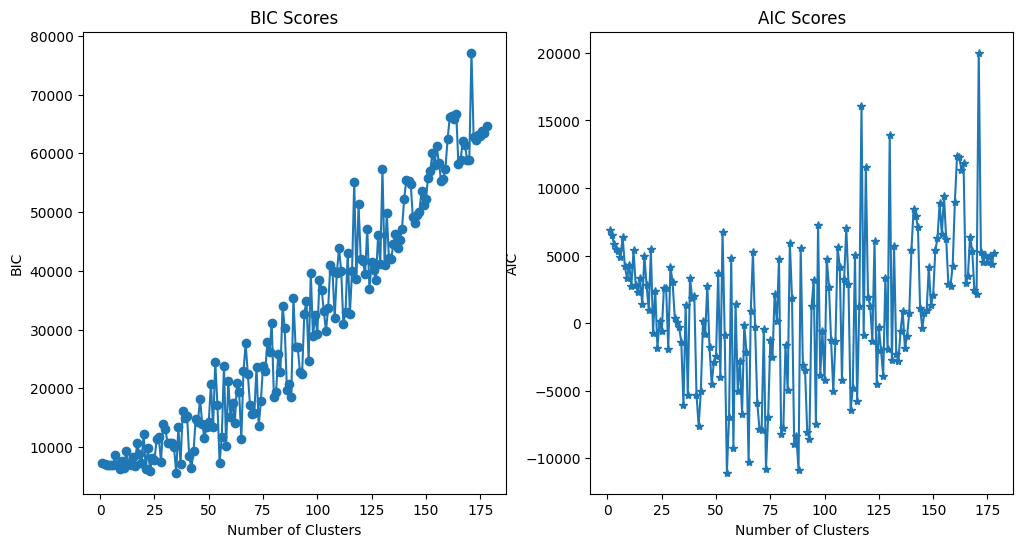

In [4]:
dataset = load_wine()
data = np.array([dataset['data']])
target = np.array([dataset['target']])
data = data.reshape((len(data[0]), len(data[0][0])))
target = target[0]

aic_scores = np.array([])
bic_scores = np.array([])

for i in range(1, target.shape[0]+1):
    gmm = GMM(data, i, 1000)
    gmm.fit(data)
    num_parameters = gmm.k * (( data.shape[1] * (data.shape[1] + 1) ) / 2) + (gmm.k - 1) + gmm.k * data.shape[1]
    bic = -2 * gmm.likelihood + np.log(target.shape[0]) * num_parameters
    aic = -2 * gmm.likelihood + 2 * num_parameters
    bic_scores = np.append(bic_scores, np.array([bic]))
    aic_scores = np.append(aic_scores, np.array([aic]))

print(bic_scores)
print(aic_scores)
print("Based upon AIC, Optimal Number of Clusters are: ", np.argmin(aic_scores)+1)
print("Based upon BIC, Optimal Number of Clusters are: ", np.argmin(bic_scores)+1)


num_clusters = np.arange(target.shape[0])+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(num_clusters, bic_scores, marker='o')
plt.title('BIC Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')

plt.subplot(1, 2, 2)
plt.plot(num_clusters, aic_scores, marker='*')
plt.title('AIC Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC')

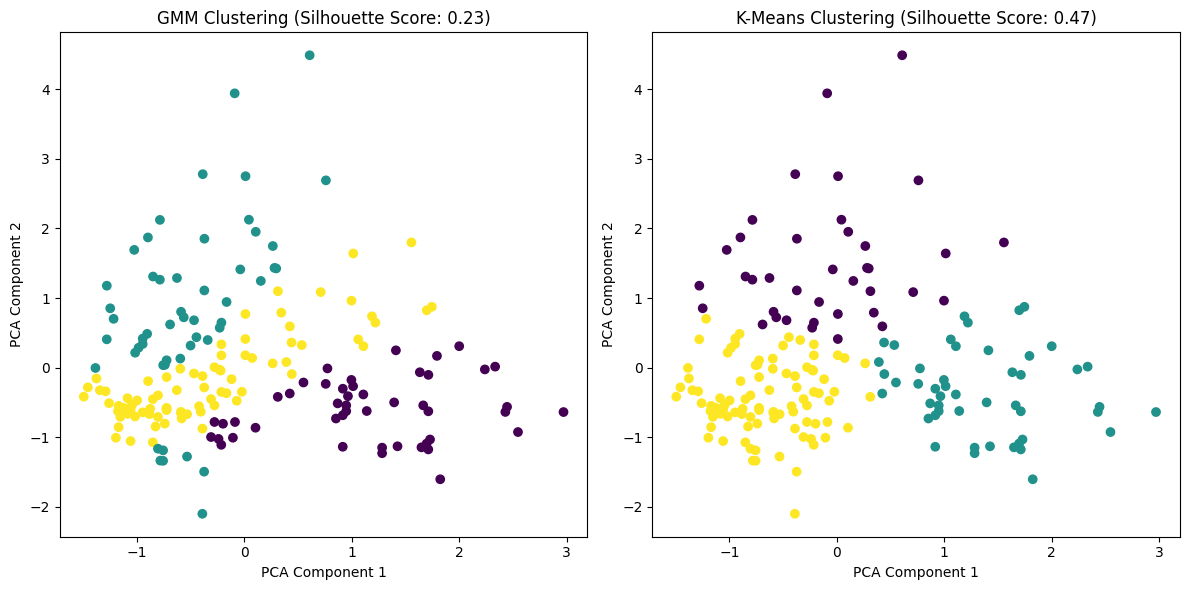

In [7]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Reduce Dataset Dimension to 2
pca = PCA(n_components = 2)
data_reduced = pca.fit_transform(data)

# AIC Information Criterion used for Optimal Cluster Marking
gmm = GMM(data_reduced, 3, 1000)
gmm.fit(data_reduced)
labels_gmm = gmm.predict()


data_scaled = data_reduced
mean = np.mean(data_scaled, axis = 0)
std = np.std(data_scaled, axis = 0)
data_scaled -= mean
data_scaled /= std
kmeans = KMeans(n_clusters=3, random_state = None, n_init="auto").fit(data_scaled)
labels_kmeans = kmeans.labels_

gmm_silhouette_score = silhouette_score(data_reduced, labels_gmm)
kmeans_silhouette_score = silhouette_score(data_scaled, labels_kmeans)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=labels_gmm, cmap='viridis')
plt.title(f'GMM Clustering (Silhouette Score: {gmm_silhouette_score:.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 2, 2)
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=labels_kmeans, cmap='viridis')
plt.title(f'K-Means Clustering (Silhouette Score: {kmeans_silhouette_score:.2f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

### Observations for GMM and K-Means Clustering 2.1.2 ###
We observe that K-means lead to Spherical Clusters, i.e has a bias towards spherical clusters, and also performs Hard-Assignments to all the Data Points. What K-means assumes is that each Data Point can belong to one class only at a particular time while GMM performs Soft Assignments or assigns probabilistic belongings to a particular class. Each Data point can belong to a particular class with a certain non-zero probability which is iteratively updated in the M-Step of the Algorithm. This does not lead to formation of Spherical Clusters and instead leads to the formation of proper clusters. That is difference between K-means and GMM is that K-means assigns a particular class to all the Data points in a particular spherical dimensional figure while on the other hand GMM assigns a particular class not on geometrical basis but on probabilistic basis. This leads to GMM also assigning Points to a particular class outside the Class's Spherical Cluster as well.

### Results ###

1. Optimal Number of Clusters (GMM):
   We determined the optimal number of clusters for GMM using the Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC).
   Based on BIC and AIC analysis, the optimal number of clusters was found to be 55 clusters for AIC and 35 for BIC crtierions respectively.

2. Dimensionality Reduction with PCA:
   We reduced the dataset's dimensionality to 2 using Principal Component Analysis (PCA), allowing for visualization in a 2D space.

3. Scatter Plots (GMM and K-Means):
   We created scatter plots to visualize the results of both GMM and K-Means clusterings in the reduced 2D space.
   The scatter plots exhibited distinct cluster formations for both algorithms.

4. Observations (GMM vs. K-Means):
   Upon visual inspection, we noted that GMM clusters exhibited more elliptical or Gaussian-like shapes, which are suitable for datasets with complex geometries and varying cluster sizes.
   K-Means clusters tended to be more spherical in shape and involved a hard assignment of data points to clusters.

5. Silhouette Scores (GMM vs. K-Means):
   We computed the silhouette scores for both GMM and K-Means clusterings. The silhouette score measures the quality of clustering results, with higher values indicating better separation between clusters.